In [ ]:
%reset

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from scipy.stats import gaussian_kde
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dense, Dropout, Activation
from keras import regularizers
import pandas as pd
from matplotlib import pyplot as plt
from keras.optimizers import RMSprop
from keras.utils import np_utils
from scipy import stats

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Plot the observed values versus predicted using density plot
def density_plot(x, y):
    ''' x = observed, y = predicted '''
    x = x[(~np.isnan(x)) & (~np.isnan(y))]
    y = y[(~np.isnan(x)) & (~np.isnan(y))]

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # formatting
#     plt.figure(figsize=[8, 6])
    plt.scatter(x, y, c=z, s=3, edgecolor='', cmap='viridis_r')
#     plt.xlim(0, 1)
#     plt.ylim(0, 1)
    plt.xlabel('Observed brightness')
    plt.ylabel('Predicted brightness')
    plt.title(chunk)
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    labelbottom="on", left="off", right="off", labelleft="on")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_color('gray')
    plt.gca().spines["left"].set_color('gray')
    plt.gca().xaxis.grid(True)
    plt.gca().yaxis.grid(True)

In [3]:
def dot_plot(char, label):
    plt.figure(figsize=[10,7])
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                        labelbottom="on", left="off", right="off", labelleft="on")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_color('gray')
    plt.gca().spines["left"].set_color('gray')
    plt.gca().xaxis.grid(True)
    plt.gca().yaxis.grid(True)
    plt.plot([x for x in range(1, 13)], char, 'ok')
    plt.xlabel('Segment', fontsize=13)
    plt.ylabel(label, fontsize=13)
    plt.xticks([x for x in range(1, 13)])

In [4]:
def read_data(chunk):
    input_file = '/home/katya/local/HIS3InterspeciesEpistasis/Analysis/Katya/NN/' + chunk + '.txt'
    data = pd.read_table(input_file)
    data.mut_list = data.mut_list.fillna('')
    unique_mutations = set(':'.join(data.mut_list).split(':'))
    unique_mutations = sorted(list(unique_mutations))
    if '' in unique_mutations:
        unique_mutations.remove('')

    data = data.reindex(np.random.permutation(data.index))
    nn_genotypes_values = np.zeros((len(data), len(unique_mutations)))
    nn_brightness_values = data.fitness.values
    
    for i in range(len(unique_mutations)):
        nn_genotypes_values[:, i] = data.mut_list.str.contains(unique_mutations[i]).astype(np.float32)

    nn_brightness_values = (nn_brightness_values - min(nn_brightness_values)) / max(
        nn_brightness_values - min(nn_brightness_values))
    
    return nn_genotypes_values, nn_brightness_values

# Batch

In [5]:
chunks = [('S'+str(x)) for x in range(1,13)]
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
biases = {}

In [29]:
for chunk in chunks:
    
    print (chunk)
    
    data, labels = read_data(chunk)
    
    model = Sequential()
    model.add(Dense(1, activation='relu', input_dim=data.shape[1], kernel_initializer='random_uniform'))
    model.add(Dense(10, activation='relu', kernel_initializer='random_uniform'))
    model.add(Dense(1, activation='relu', kernel_initializer='random_uniform'))

    model.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  verbose=0)
    
    hist[chunk] = model.fit(data, labels, epochs=500, batch_size=500, shuffle=True, verbose=0)
    proba = model.predict_proba(data, batch_size=500, verbose=0)
    
    weights[chunk] = model.layers[0].get_weights()[0]
    biases[chunk] = model.layers[0].get_weights()[1]
    
    true[chunk] = labels
    predicted[chunk] = proba.flatten()
    fitness_potential[chunk] = data.dot(weights[chunk])

S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12


LinAlgError: singular matrix

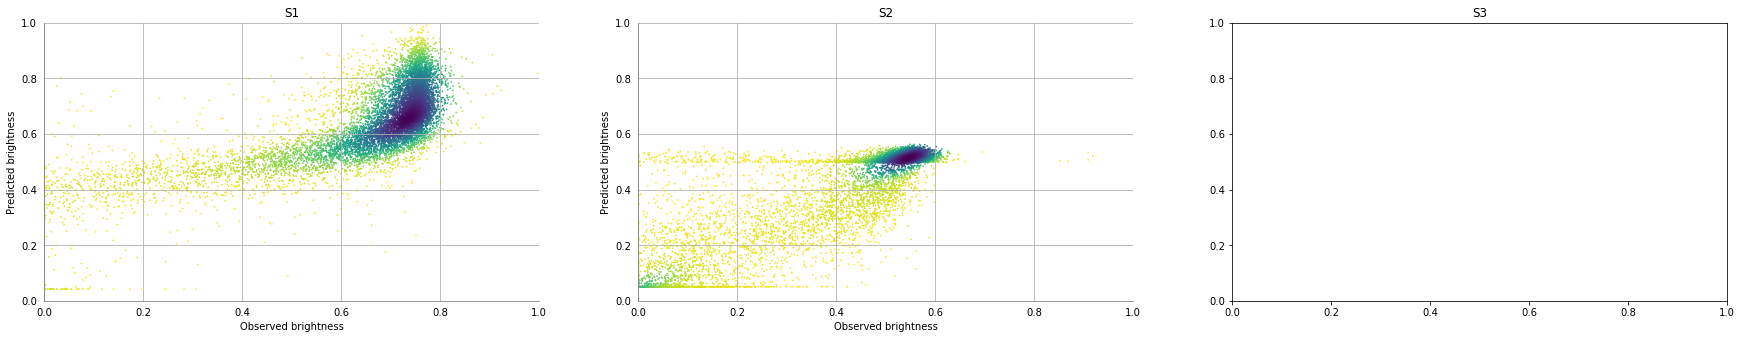

In [32]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.ylim(0,1)
    plt.xlim(0,1)
    density_plot(true[chunk][:10000], predicted[chunk][:10000])
    count+=1

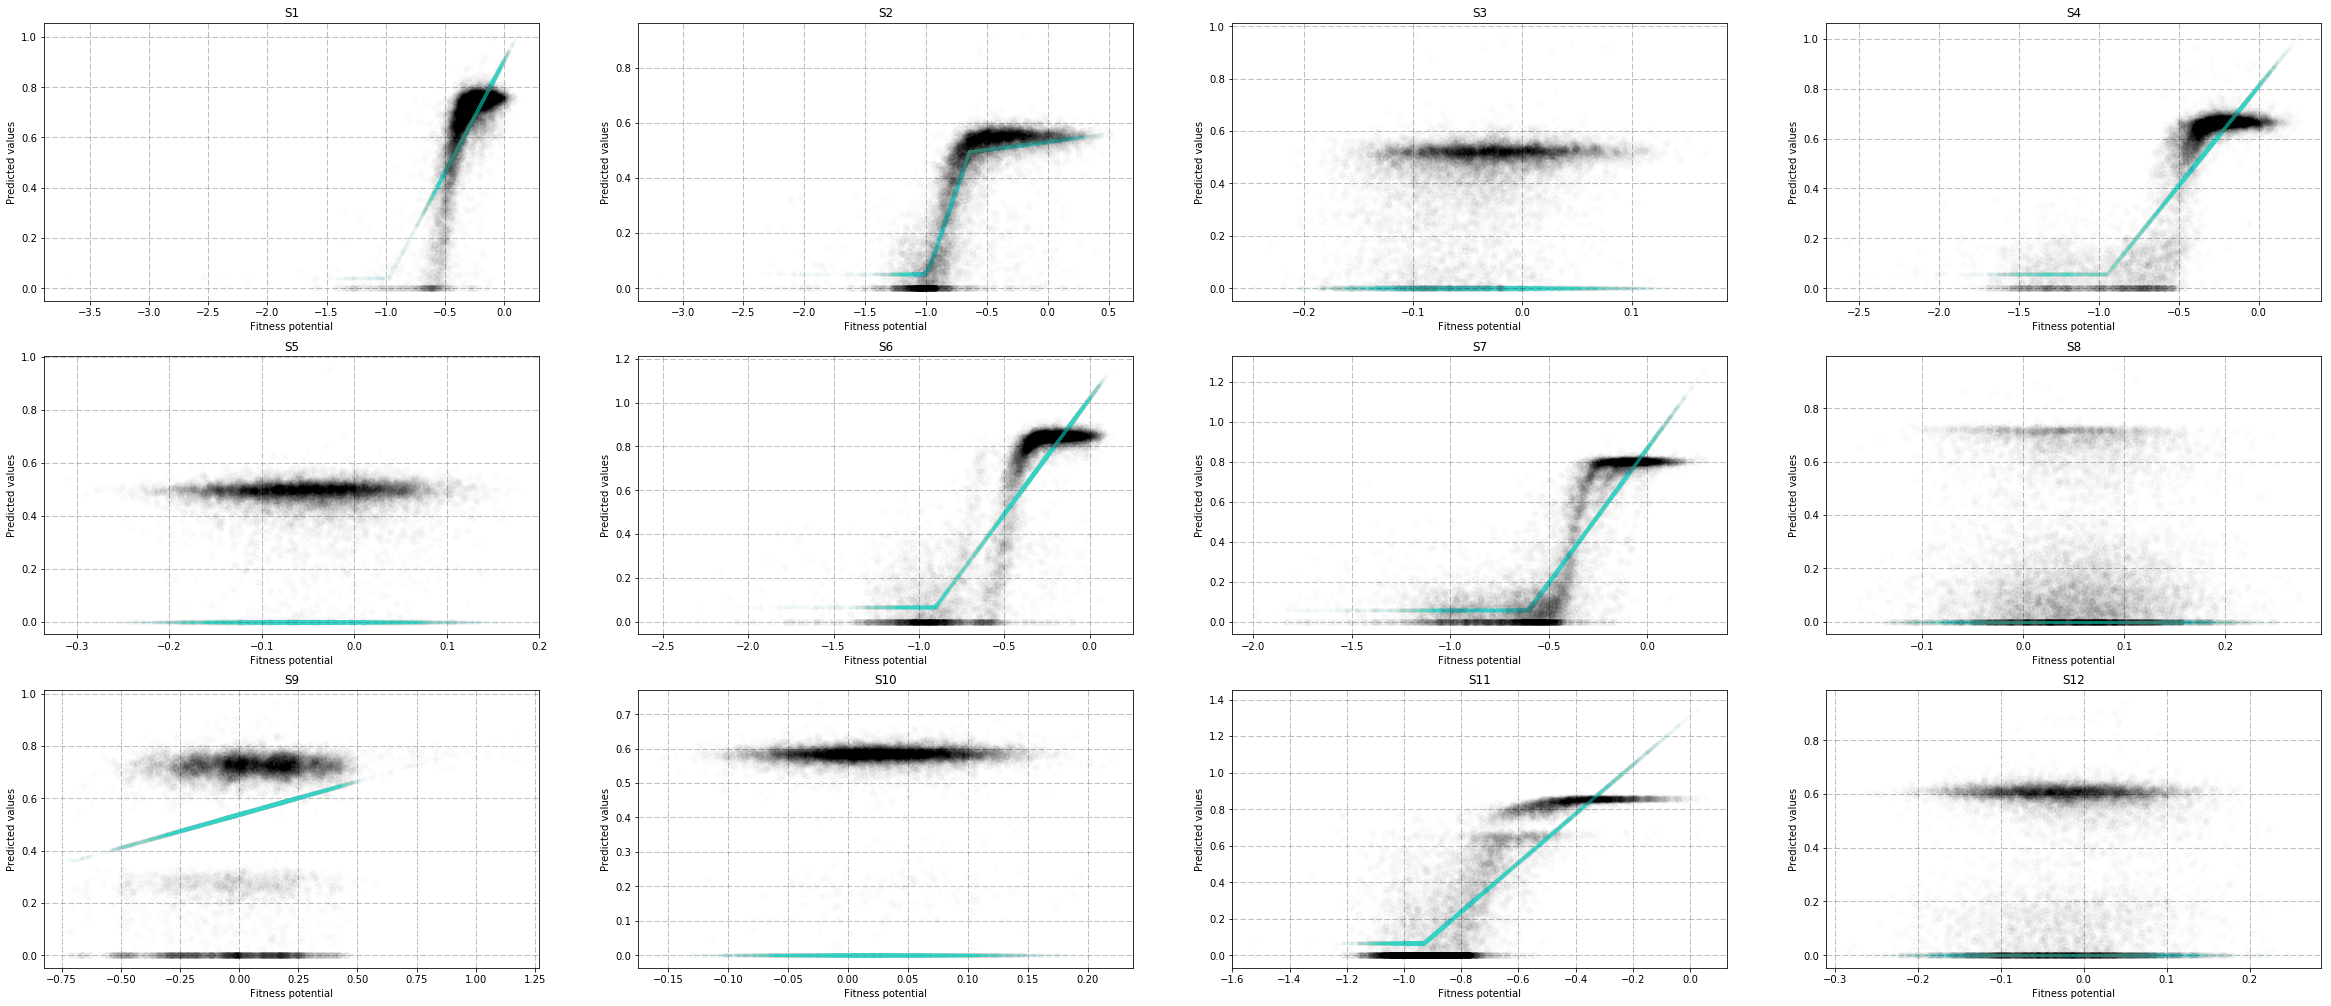

In [30]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    X = fitness_potential[chunk][:10000]
    Y = true[chunk][:10000]
    plt.plot(X, Y, 'ok', alpha = 0.01)
    plt.plot(X, predicted[chunk][:10000], '.', c='#36D1C4', alpha = 0.01)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Fitness potential')
    plt.ylabel('Predicted values')
    count+=1

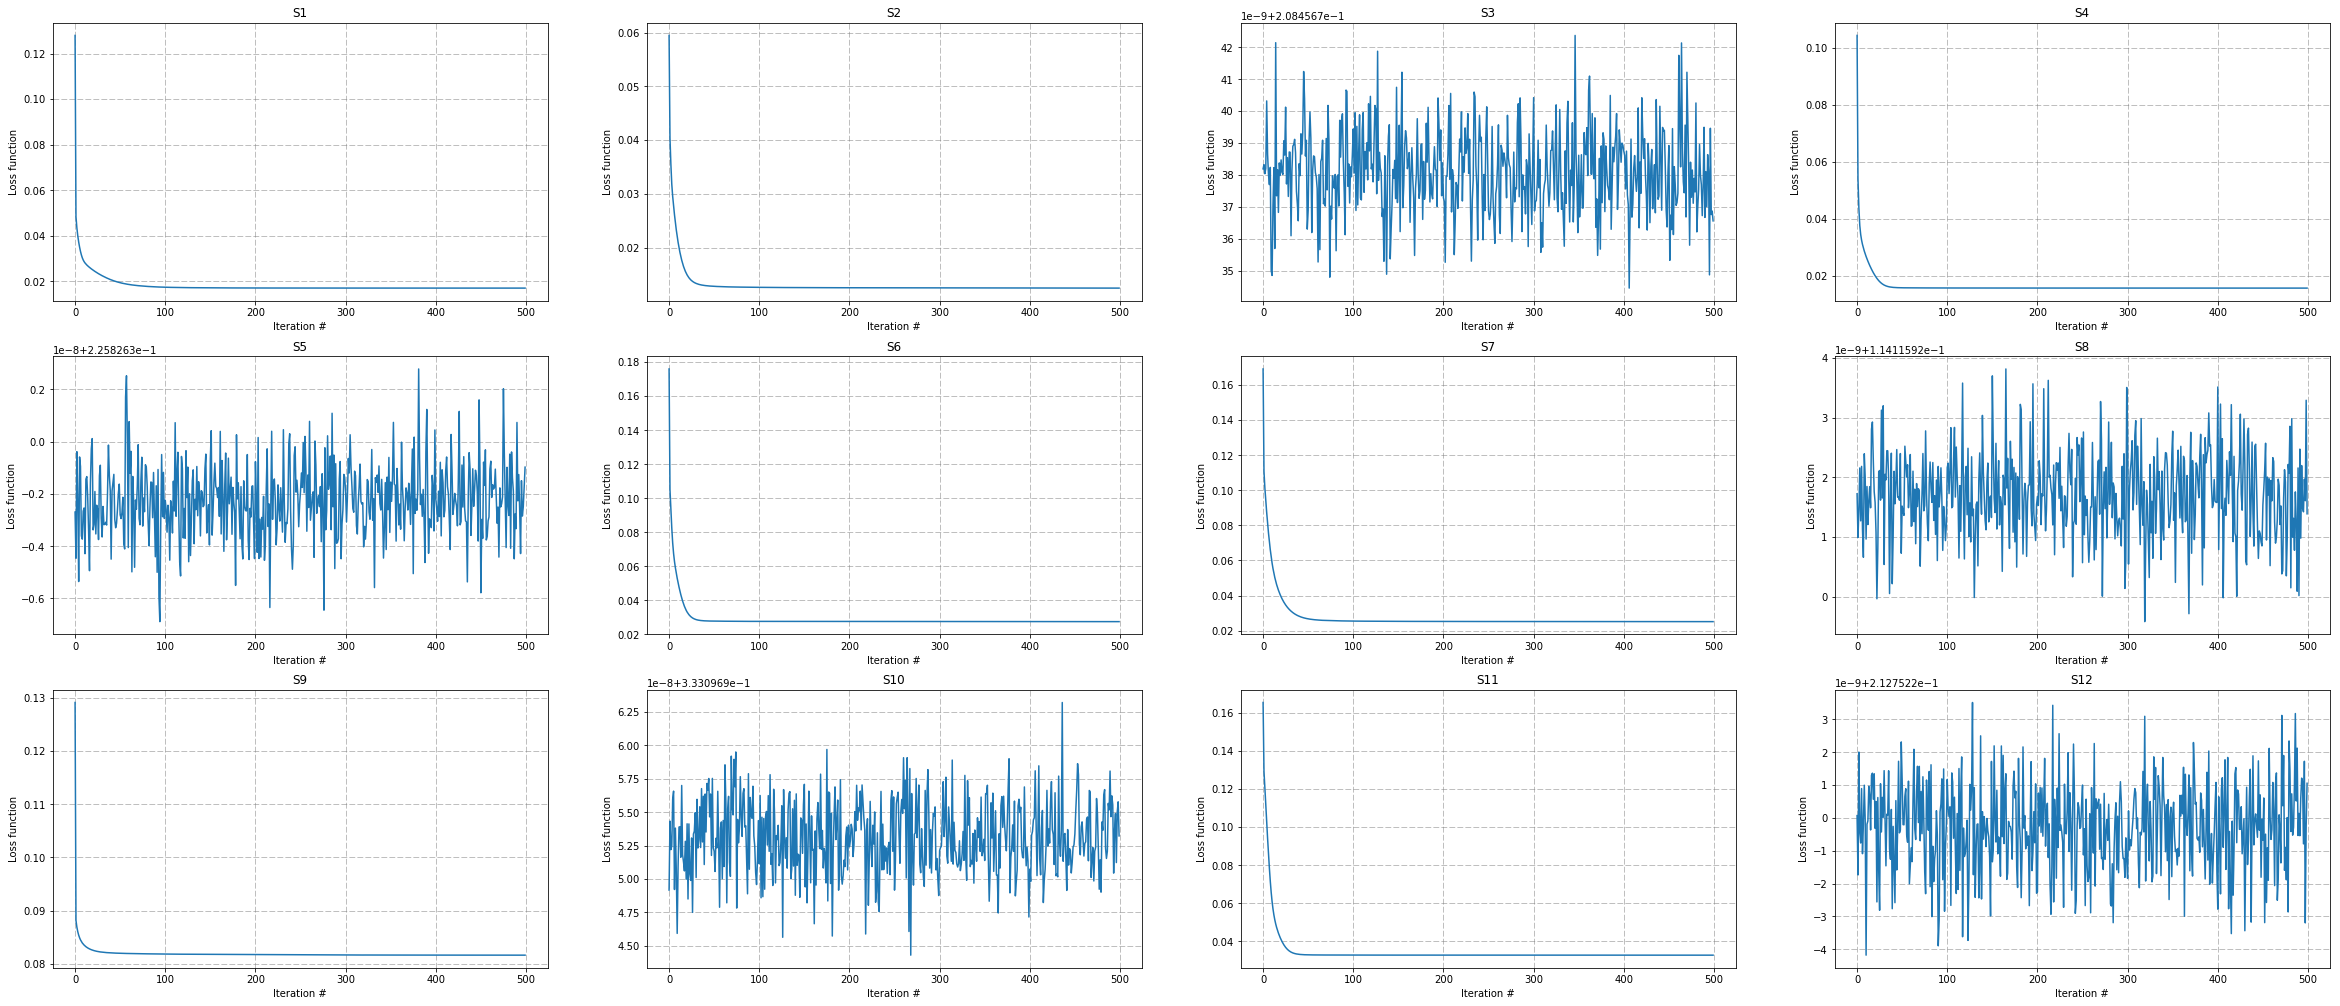

In [33]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.plot([x for x in range(500)], hist[chunk].history['loss'])
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss function')
    count+=1

## Correlations

In [22]:
r_values = []

for chunk in chunks:
    slope, intercept, r_value, p_value, std_err = stats.linregress(true[chunk], predicted[chunk])
    r_values.append(r_value)

In [23]:
mse = []

for chunk in chunks:
    mse.append(hist[chunk].history['loss'][-1])

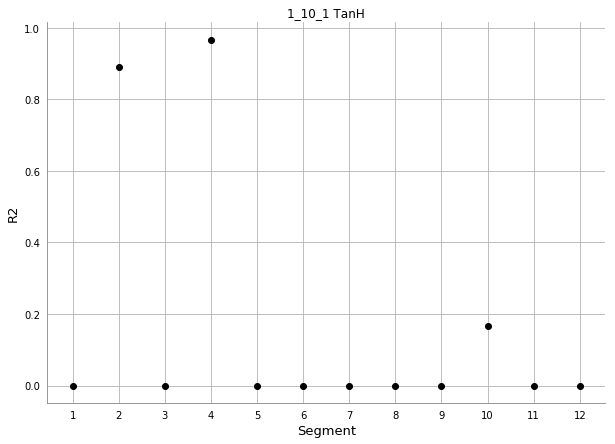

In [24]:
dot_plot(r_values, 'R2')
plt.title('1_10_1 TanH');

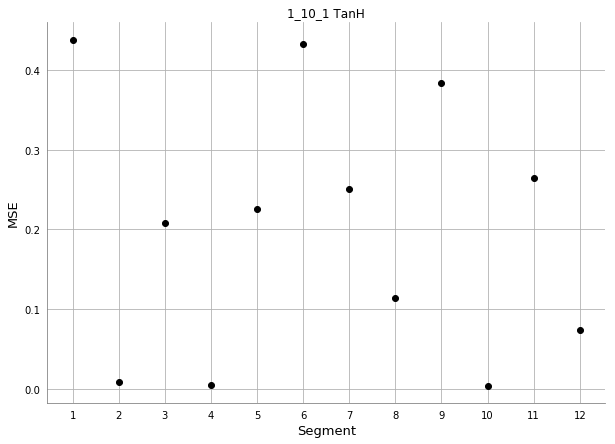

In [25]:
dot_plot(mse, 'MSE')
plt.title('1_10_1 TanH');

In [26]:
x

12